In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE

In [3]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Overdrive"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES_PER_SETTING = 500
NUM_SETTINGS = 20
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/3kdv9ddi/checkpoints/epoch=820-step=513125.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [4]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [5]:
def get_dataset(dafx):
    dataset = PairedAudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES_PER_SETTING,
        augmentations={},
        length=131_072,
        effect_input=False,
        effect_output=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [6]:
dafx = dafx_from_name(DAFX_NAME)

In [7]:
def get_interpolated_settings(dafx):
    num_settings = len(dafx.param_names)
    settings = [torch.ones(num_settings) * i for i in np.linspace(0, 1, NUM_SETTINGS)]
    return settings

In [8]:
settings_to_apply = get_interpolated_settings(dafx)


In [9]:
settings_to_apply

[tensor([0., 0., 0.]),
 tensor([0.0526, 0.0526, 0.0526]),
 tensor([0.1053, 0.1053, 0.1053]),
 tensor([0.1579, 0.1579, 0.1579]),
 tensor([0.2105, 0.2105, 0.2105]),
 tensor([0.2632, 0.2632, 0.2632]),
 tensor([0.3158, 0.3158, 0.3158]),
 tensor([0.3684, 0.3684, 0.3684]),
 tensor([0.4211, 0.4211, 0.4211]),
 tensor([0.4737, 0.4737, 0.4737]),
 tensor([0.5263, 0.5263, 0.5263]),
 tensor([0.5789, 0.5789, 0.5789]),
 tensor([0.6316, 0.6316, 0.6316]),
 tensor([0.6842, 0.6842, 0.6842]),
 tensor([0.7368, 0.7368, 0.7368]),
 tensor([0.7895, 0.7895, 0.7895]),
 tensor([0.8421, 0.8421, 0.8421]),
 tensor([0.8947, 0.8947, 0.8947]),
 tensor([0.9474, 0.9474, 0.9474]),
 tensor([1., 1., 1.])]

In [10]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)
model.eval()

StyleTransferVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=4096, bias=True)
  (log_var): Linear(in_features=2064

In [11]:
latent_embeddings = dict()

In [12]:
dataset = get_dataset(dafx_from_name('clean'))

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 40933.65it/s]


Loaded 88 files for train = 66.89 hours.


In [13]:
from tqdm import tqdm

for setting in settings_to_apply:
    print("Applying setting: ", setting)
    embeddings = []
    for batch in tqdm(dataset):
        x, y = batch

        # Apply setting to audio
        y = dafx.apply(y, setting)
        y = y.unsqueeze(0).unsqueeze(0)

        x_s = model.audio_to_spectrogram(signal=x, return_phase=False)
        y_s = model.audio_to_spectrogram(signal=y, return_phase=False)

        X = torch.concat([x_s, y_s], dim=1)

        _, _, _, z = model(X)

        embeddings.append(z.detach().numpy())

    fx = setting[0].item()
    latent_embeddings[str(fx)] = np.array(embeddings)

Applying setting:  tensor([0., 0., 0.])


100%|██████████| 500/500 [00:24<00:00, 20.37it/s]


Applying setting:  tensor([0.0526, 0.0526, 0.0526])


100%|██████████| 500/500 [00:24<00:00, 20.61it/s]


Applying setting:  tensor([0.1053, 0.1053, 0.1053])


100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Applying setting:  tensor([0.1579, 0.1579, 0.1579])


100%|██████████| 500/500 [00:24<00:00, 20.37it/s]


Applying setting:  tensor([0.2105, 0.2105, 0.2105])


100%|██████████| 500/500 [00:24<00:00, 20.29it/s]


Applying setting:  tensor([0.2632, 0.2632, 0.2632])


100%|██████████| 500/500 [00:24<00:00, 20.82it/s]


Applying setting:  tensor([0.3158, 0.3158, 0.3158])


100%|██████████| 500/500 [00:23<00:00, 21.17it/s]


Applying setting:  tensor([0.3684, 0.3684, 0.3684])


100%|██████████| 500/500 [00:23<00:00, 21.28it/s]


Applying setting:  tensor([0.4211, 0.4211, 0.4211])


100%|██████████| 500/500 [00:23<00:00, 21.18it/s]


Applying setting:  tensor([0.4737, 0.4737, 0.4737])


100%|██████████| 500/500 [00:23<00:00, 21.10it/s]


Applying setting:  tensor([0.5263, 0.5263, 0.5263])


100%|██████████| 500/500 [00:23<00:00, 21.18it/s]


Applying setting:  tensor([0.5789, 0.5789, 0.5789])


100%|██████████| 500/500 [00:25<00:00, 19.90it/s]


Applying setting:  tensor([0.6316, 0.6316, 0.6316])


100%|██████████| 500/500 [00:24<00:00, 20.30it/s]


Applying setting:  tensor([0.6842, 0.6842, 0.6842])


100%|██████████| 500/500 [00:24<00:00, 20.26it/s]


Applying setting:  tensor([0.7368, 0.7368, 0.7368])


100%|██████████| 500/500 [00:23<00:00, 21.10it/s]


Applying setting:  tensor([0.7895, 0.7895, 0.7895])


100%|██████████| 500/500 [00:23<00:00, 21.39it/s]


Applying setting:  tensor([0.8421, 0.8421, 0.8421])


100%|██████████| 500/500 [00:23<00:00, 21.12it/s]


Applying setting:  tensor([0.8947, 0.8947, 0.8947])


100%|██████████| 500/500 [00:24<00:00, 20.24it/s]


Applying setting:  tensor([0.9474, 0.9474, 0.9474])


100%|██████████| 500/500 [00:24<00:00, 20.34it/s]


Applying setting:  tensor([1., 1., 1.])


100%|██████████| 500/500 [00:24<00:00, 20.34it/s]


In [14]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [15]:
import umap

In [16]:
reducer = umap.UMAP().fit(data)

In [17]:
# for fx, X in latent_embeddings.items():
#     embeds = reducer.transform(X.squeeze())
#     plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.6, s=0.6)
#
# plt.gca().set_aspect('equal', 'datalim')
# plt.title(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")
#
# lgnd = plt.legend()
# for i in range(len(latent_embeddings.keys())):
#     lgnd.legendHandles[i]._sizes = [30]
#
# plt.savefig(f"./figures/{CHECKPOINT_ID}_{DAFX_NAME}_{NUM_SETTINGS}multisetting_latent_embeddings.svg")

In [18]:
colours = np.array([np.array([setting[0]]*NUM_EXAMPLES_PER_SETTING) for setting in settings_to_apply])

In [19]:
embeds = reducer.transform(data)

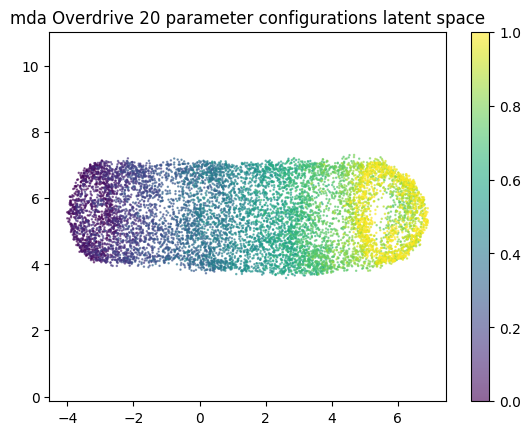

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

sc = ax.scatter(x=embeds[:,0], y=embeds[:,1], c=colours, vmin=0, vmax=1, alpha=0.6, s=0.6, cmap='viridis')

plt.colorbar(sc)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

# lgnd = plt.legend()
# for i in range(len(latent_embeddings.keys())):
#     lgnd.legendHandles[i]._sizes = [30]

plt.savefig(f"./figures/{CHECKPOINT_ID}_{DAFX_NAME}_{NUM_SETTINGS}multisetting_latent_embeddings_cmap.svg")